# Setup

In [1]:
!pip install opendatasets -q

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import opendatasets as od

# Data Loading

In [3]:
od.download('https://www.kaggle.com/datasets/saadhaxxan/germantrafficsigns')

100%|██████████| 118M/118M [00:06<00:00, 19.8MB/s]


In [4]:
training_file = '/content/germantrafficsigns/train.p'
testing_file = '/content/germantrafficsigns/test.p'

# Open and load the training file
with open(training_file, mode='rb') as f:
  train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
  test = pickle.load(f)

print("Data Loaded")

Data Loaded


# Data Exploration  

In [5]:
# create pandas df to load signnames.csv which has Classid and SignName

sign_name_df = pd.read_csv('/content/germantrafficsigns/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


## Split features and targets

In [6]:
# Split feature and target for training data
X, y = train['features'], train['labels']

# Change lists into np arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Split feature and target for testing data
X_test, y_test = test['features'], test['labels']

# Change lists into np arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


## Split into train and val

In [7]:
# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=64)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


## Visualize class distribution

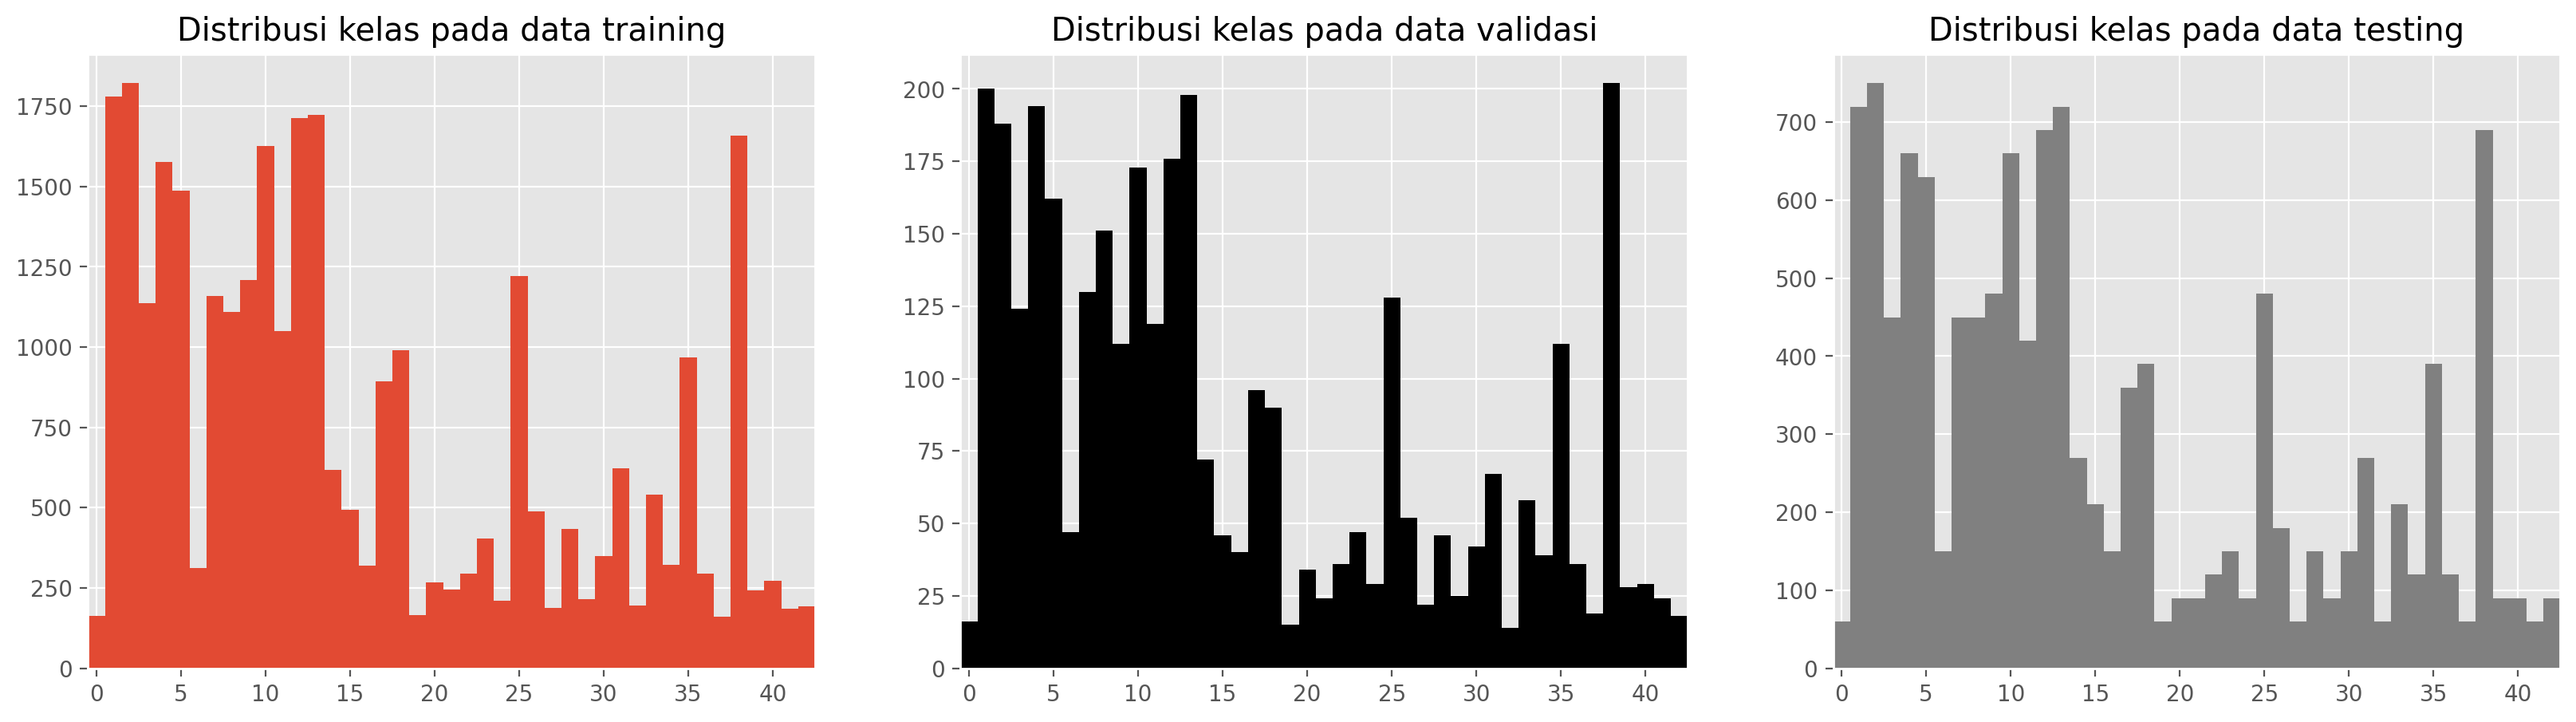

In [8]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
  if not ax :
    fig = plt.figure()
    ax = fig.add_subplot(111)

  ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
  ax.set_xlim(-0.5, n_labels-0.5)
  if 'label' in kwargs : ax.legend()
  if title : ax.set_title(title)

fig, ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data testing', ax=ax[2], color='grey')

## One Hot Encoding

In [9]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# Model Development

In [10]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%, Stop training!")
      self.model.stop_training=True

callbacks=MyCallback()

In [11]:
model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(32, (5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 18s 7ms/step - loss: 1.6604 - accuracy: 0.6021 - val_loss: 0.3849 - val_accuracy: 0.9069
Epoch 2/25
979/979 [==============================] - 6s 6ms/step - loss: 0.5967 - accuracy: 0.8236 - val_loss: 0.2557 - val_accuracy: 0.9325
Epoch 3/25
979/979 [==============================] - 6s 6ms/step - loss: 0.4326 - accuracy: 0.8700 - val_loss: 0.1735 - val_accuracy: 0.9583
Epoch 4/25
979/979 [==============================] - 5s 5ms/step - loss: 0.3339 - accuracy: 0.9013 - val_loss: 0.1576 - val_accuracy: 0.9546
Epoch 5/25
979/979 [==============================] - 6s 6ms/step - loss: 0.2803 - accuracy: 0.9169 - val_loss: 0.0778 - val_accuracy: 0.9805
Epoch 6/25
979/979 [==============================] - 6s 6ms/step - loss: 0.2437 - accuracy: 0.9276 - val_loss: 0.1062 - val_accuracy: 0.9681
Epoch 7/25
979/979 [==============================] - 6s 6ms/step - loss: 0.2259 - accuracy: 0.9318 - val_loss: 0.0722 - val_accuracy: 0.9790
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


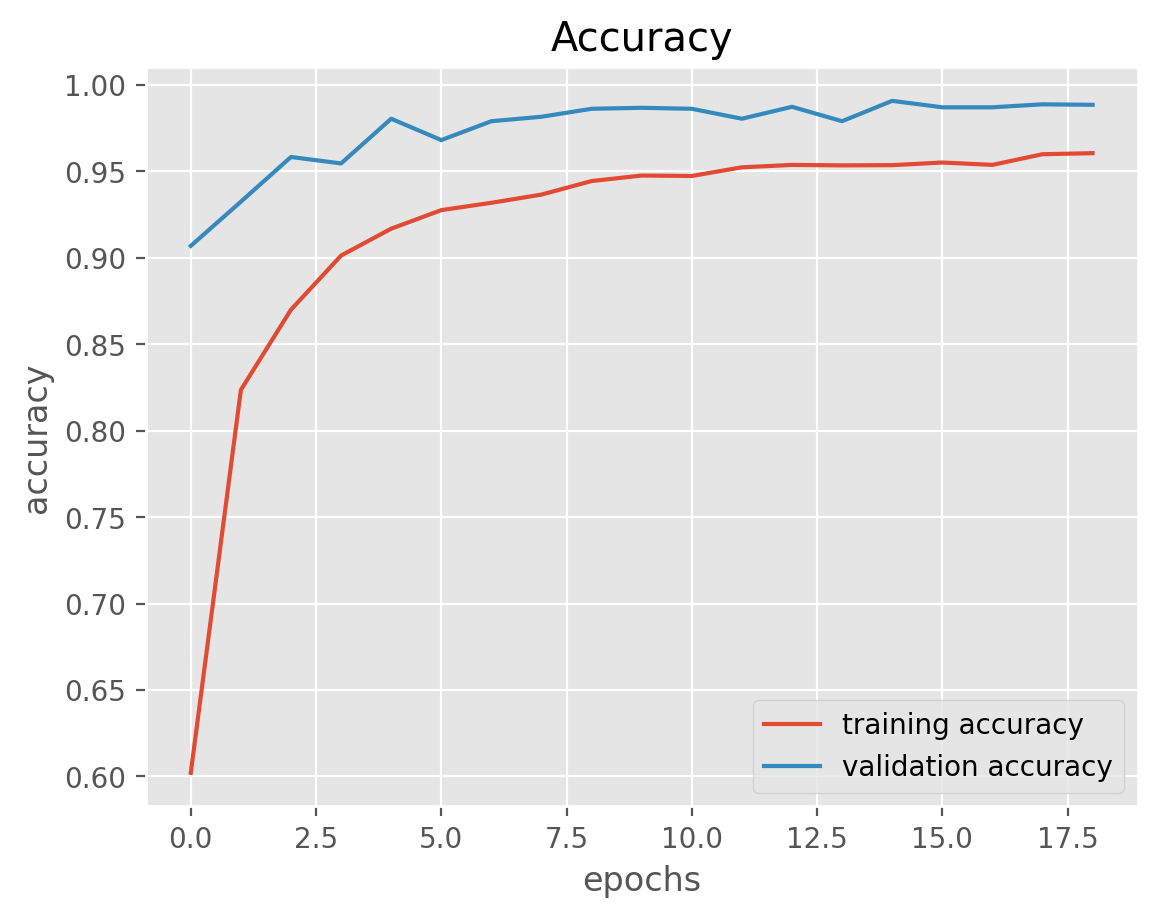

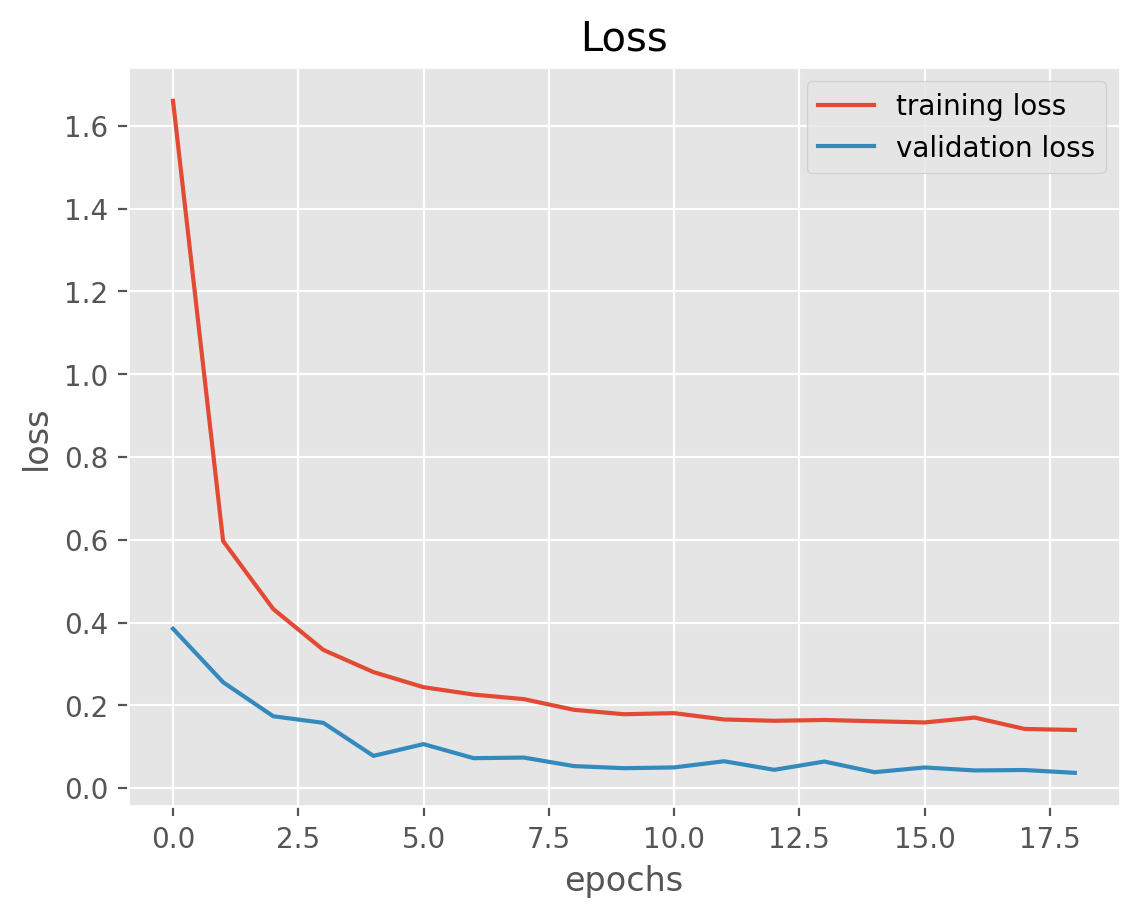

In [14]:
# plot accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# plot loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Model Testing

In [16]:
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 1s 3ms/step


0.9371338083927158

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        60
           1       0.94      0.95      0.94       720
           2       0.97      0.97      0.97       750
           3       0.90      0.95      0.92       450
           4       0.95      0.95      0.95       660
           5       0.90      0.93      0.92       630
           6       0.95      0.81      0.87       150
           7       0.96      0.98      0.97       450
           8       0.94      0.92      0.93       450
           9       1.00      1.00      1.00       480
          10       1.00      0.98      0.99       660
          11       0.92      0.96      0.94       420
          12       0.97      0.98      0.97       690
          13       0.98      0.98      0.98       720
          14       1.00      0.99      0.99       270
          15       0.96      0.96      0.96       210
          16       0.98      0.99      0.99       150
          17       1.00    